# Business Problem:

Our main business objectives are to understand the dynamics of the labour market of Armenia using the online job portal post as a proxy.

### Import necessary packages

In [1]:
import numpy as np
import pandas as pd

#for charts
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud      #need to install wordcloud package

In [2]:
#for text processing
import string
import re
import nltk
from textblob import TextBlob

In [3]:
#for tokenization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#for feature selection
from sklearn import decomposition

#for model building
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report

### Import data

In [4]:
jobs = pd.read_csv('data job posts.csv')

In [5]:
jobs.head().T

,0,1,2,3,4
jobpost,AMERIA Investment Consulting Company\nJOB TITL...,International Research & Exchanges Board (IREX...,Caucasus Environmental NGO Network (CENN)\nJOB...,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,Yerevan Brandy Company\nJOB TITLE: Software D...
date,"Jan 5, 2004","Jan 7, 2004","Jan 7, 2004","Jan 7, 2004","Jan 10, 2004"
Title,Chief Financial Officer,Full-time Community Connections Intern (paid i...,Country Coordinator,BCC Specialist,Software Developer
Company,AMERIA Investment Consulting Company,International Research & Exchanges Board (IREX),Caucasus Environmental NGO Network (CENN),Manoff Group,Yerevan Brandy Company
AnnouncementCode,NaN,NaN,NaN,NaN,NaN
Term,NaN,NaN,NaN,NaN,NaN
Eligibility,NaN,NaN,NaN,NaN,NaN
Audience,NaN,NaN,NaN,NaN,NaN
StartDate,NaN,NaN,NaN,NaN,NaN
Duration,NaN,3 months,Renewable annual contract\nPOSITION,NaN,NaN


In [6]:
jobs.shape

(19001, 24)

In [7]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19001 entries, 0 to 19000
Data columns (total 24 columns):
jobpost             19001 non-null object
date                19001 non-null object
Title               18973 non-null object
Company             18994 non-null object
AnnouncementCode    1208 non-null object
Term                7676 non-null object
Eligibility         4930 non-null object
Audience            640 non-null object
StartDate           9675 non-null object
Duration            10798 non-null object
Location            18969 non-null object
JobDescription      15109 non-null object
JobRequirment       16479 non-null object
RequiredQual        18517 non-null object
Salary              9622 non-null object
ApplicationP        18941 non-null object
OpeningDate         18295 non-null object
Deadline            18936 non-null object
Notes               2211 non-null object
AboutC              12470 non-null object
Attach              1559 non-null object
Year              

In [8]:
#lowercase the column names
jobs.columns = jobs.columns.str.lower()

In [9]:
jobs.columns

Index(['jobpost', 'date', 'title', 'company', 'announcementcode', 'term',
       'eligibility', 'audience', 'startdate', 'duration', 'location',
       'jobdescription', 'jobrequirment', 'requiredqual', 'salary',
       'applicationp', 'openingdate', 'deadline', 'notes', 'aboutc', 'attach',
       'year', 'month', 'it'],
      dtype='object')

### Data Cleaning

In [10]:
#removing duplicate jobposts based on title and post
jobs = jobs.drop_duplicates(['jobpost', 'title'])

In [11]:
jobs.shape

(18892, 24)

In [12]:
#removing records with null title
#jobs = jobs[jobs.title.notna()]
#jobs.shape

## Type of demanding jobs in Armenia

**1. Preprocessing the text data**

In [13]:
jobs['title'] = jobs['title'].astype('str')

In [14]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [15]:
#UDF to do basic cleaning of title column to understand type of jobs
def clean_data(text):
    text = text.lower()  # convert all the text into lowercase
    text = text.strip()  #remove starting and trailing whitespaces
    #special_chars = re.compile('[@!#$%^&*()<>?/\|}{~:;]')
    #text = re.sub(special_chars,'', text)
    special_char_reg = '([a-zA-Z0-9]+)' + '[!"#$%&\'()*+,-./:;<=>?@\\^_`{|}~]' + '([a-zA-Z0-9]+)'
    text = re.sub(special_char_reg, ' ', text)
    text = re.sub(r'\s+', ' ', text) #remove all line formattings
    text = re.sub(r'\d+', '', text) #remove digits
    text = ''.join(c for c in text if c not in string.punctuation)   #remove pecial symbols from job titles
    return text

In [16]:
a = 'Ful8l-ti9me Community Connections f09:053yy'
special_char_reg = '([a-zA-Z0-9]+)' + '[!"#$%&\'()*+,-./:;<=>?@\\^_`{|}~]' + '([a-zA-Z0-9]+)'
re.sub(special_char_reg, ' ', a).strip()

'Community Connections'

In [17]:
jobs.title.head(6)

0                              Chief Financial Officer
1    Full-time Community Connections Intern (paid i...
2                                  Country Coordinator
3                                       BCC Specialist
4                                   Software Developer
5                                           Saleswoman
Name: title, dtype: object

In [18]:
title_df = jobs.title.apply(lambda x : clean_data(x))
title_df.head()

0                          chief financial officer
1     community connections intern paid internship
2                              country coordinator
3                                   bcc specialist
4                               software developer
Name: title, dtype: object

In [19]:
from nltk import WordNetLemmatizer
#nltk.download('punkt')

In [20]:
#nltk.download('wordnet')

In [21]:
def lemma(text):
    word_list = nltk.word_tokenize(text) #tokenize beofre lemmatization
    lemma_output = ' '.join(WordNetLemmatizer().lemmatize(word) for word in word_list)
    return lemma_output

In [22]:
# Define the sentence to be lemmatized
sentence = "public bats outreach and strengthening of a growth"
sentence = "The striped bats are hanging on their feet for best"
# Tokenize: Split the sentence into words
word_list = nltk.word_tokenize(sentence)
print(word_list)
#> ['The', 'striped', 'bats', 'are', 'hanging', 'on', 'their', 'feet', 'for', 'best']

# Lemmatize list of words and join
lemmatized_output = ' '.join([WordNetLemmatizer().lemmatize(w) for w in word_list])
print(lemmatized_output)

['The', 'striped', 'bats', 'are', 'hanging', 'on', 'their', 'feet', 'for', 'best']
The striped bat are hanging on their foot for best


In [23]:
##Lematization
import spacy
#neccesary to download the english model using "python -m spacy download en"
nlp = spacy.load('en_core_web_sm')
# Parse the sentence using the loaded 'en' model object `nlp`
doc = nlp(sentence)

# Extract the lemma for each token and join
" ".join([token.lemma_ for token in doc])

'the stripe bat be hang on -PRON- foot for good'

In [24]:
title_df_1 = title_df.apply(lambda x : lemma(x))

In [25]:
title_df_1.head()

0                        chief financial officer
1    community connection intern paid internship
2                            country coordinator
3                                 bcc specialist
4                             software developer
Name: title, dtype: object

In [26]:
#Stop words removal
stop = nltk.corpus.stopwords.words('english')
#stop.extend(['armenian', 'armenia', 'job', 'title', 'position', 'location', 'responsibilities', 'application',
#                  'procedures', 'deadline', 'required','qualifications', 'renumeration', 'salary', 'date', 'company', 'llc'])

In [27]:
title_df_1 = title_df_1.apply(lambda x : ' '.join(x for x in x.split() if x not in stop))

In [28]:
title_df_1.head()

0                        chief financial officer
1    community connection intern paid internship
2                            country coordinator
3                                 bcc specialist
4                             software developer
Name: title, dtype: object

Now to undertand the most demanding jobs in armenia we can create a **bi/tri gram DTM** on the job titles and find the most occuring token to be the most demanding job

In [29]:
#Tokenization using count vectorizer
count_vect = CountVectorizer(ngram_range=(1,1))
token = count_vect.fit_transform(title_df_1)

In [30]:
token

<18892x2542 sparse matrix of type '<class 'numpy.int64'>'
	with 53675 stored elements in Compressed Sparse Row format>

In [31]:
print(count_vect.get_feature_names())

['aacas', 'abap', 'abatement', 'abattoir', 'abkhazia', 'abovyan', 'abuse', 'academy', 'acca', 'access', 'accident', 'account', 'accountability', 'accountancy', 'accountant', 'accounting', 'achajour', 'acquiring', 'acquisition', 'act', 'action', 'actionscript', 'activation', 'active', 'activity', 'actuarial', 'actuary', 'ad', 'adaptation', 'adb', 'added', 'addition', 'address', 'adherence', 'adjuster', 'adjustor', 'admin', 'administration', 'administrative', 'administrator', 'adminsitrative', 'adminstration', 'adminstrative', 'adminstrator', 'admission', 'adobe', 'adolescent', 'adp', 'advanced', 'adventure', 'advertisement', 'advertising', 'advertizing', 'adviser', 'advising', 'advisor', 'advisory', 'advocacy', 'advocate', 'aerobics', 'affair', 'affiliate', 'affluent', 'agency', 'agent', 'agile', 'agreement', 'agribusiness', 'agricultural', 'agriculture', 'agriculturist', 'agro', 'agronomist', 'agroprocessing', 'aid', 'aide', 'aided', 'aiming', 'air', 'aircraft', 'airline', 'airport', '

In [32]:
print('Total number of tokens/words in all the job titles - ', len(count_vect.get_feature_names()))

Total number of tokens/words in all the job titles -  2542


In [33]:
temp_df =  pd.DataFrame(token.toarray(), columns=count_vect.get_feature_names())
temp_df.tail()

,aacas,abap,abatement,abattoir,abkhazia,abovyan,abuse,academy,acca,access,...,yield,yoga,young,youth,zang,zend,zonal,zone,zooplankton,zvartnots
18887,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18888,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18889,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18890,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18891,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
#count the accurence of each token in entire corpus
count_df = temp_df.apply(lambda x : x.sum())

In [35]:
count_df = pd.DataFrame(count_df).reset_index()

In [36]:
count_df.columns = ['Word', 'Count']

In [37]:
top_jobs = count_df.sort_index(by= 'Count', ascending=False)

C:\Users\Yoga 500\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


In [38]:
top_jobs[:10]

,Word,Count
1382,manager,2587
2134,specialist,2067
661,developer,1942
797,engineer,1601
2053,senior,1490
179,assistant,1234
2115,software,1099
2003,sale,855
14,accountant,779
649,department,742


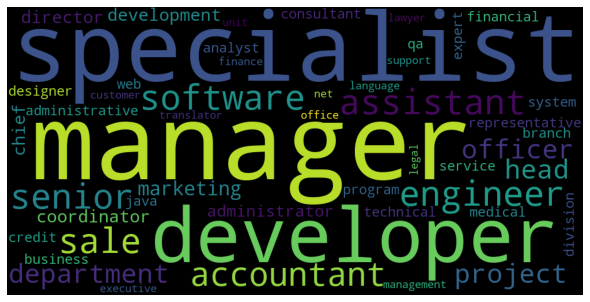

In [39]:
# plot the WordCloud image to show top 50 type of demanding jobs in armenia     
wordcloud = WordCloud(width = 1000, height = 500).generate(' '.join(top_jobs[:50].Word))
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Job Nature changing over time

We can use dispersion plot to see how jobs change over time. To do this we need to get the important topics out of the jobpost and then plot their dispersion over time.

In [40]:
jobs['jobpost'] = jobs['jobpost'].astype('str')

In [41]:
#UDF to do basic cleaning of title column to understand type of jobs
def clean_data(text):
    text = text.lower()  # convert all the text into lowercase
    text = text.strip()  #remove starting and trailing whitespaces
    #special_chars = re.compile('[@!#$%^&*()<>?/\|}{~:;]')
    #text = re.sub(special_chars,'', text)
    special_char_reg = '([a-zA-Z0-9]+)' + '[!"#$%&\'()*+,-./:;<=>?@\\^_`{|}~]' + '([a-zA-Z0-9]+)'
    text = re.sub(special_char_reg, ' ', text)
    text = re.sub(r'\s+', ' ', text) #remove all line formattings
    text = re.sub(r'\d+', '', text) #remove digits
    text = ''.join(c for c in text if c not in string.punctuation)   #remove pecial symbols from job titles
    return text

In [42]:
jobs.jobpost.head()

0    AMERIA Investment Consulting Company\nJOB TITL...
1    International Research & Exchanges Board (IREX...
2    Caucasus Environmental NGO Network (CENN)\nJOB...
3    Manoff Group\nJOB TITLE:  BCC Specialist\nPOSI...
4    Yerevan Brandy Company\nJOB TITLE:  Software D...
Name: jobpost, dtype: object

In [43]:
jobpost_df = jobs.jobpost.apply(lambda x : clean_data(x))

In [44]:
jobpost_df.head(10)

0    ameria investment consulting company job title...
1    international research  exchanges board irex t...
2    caucasus environmental ngo network cenn job ti...
3    manoff group job title bcc specialist position...
4    yerevan brandy company job title software deve...
5    boutique appollo job title saleswoman position...
6    osi assistance foundation  armenian branch off...
7    international research  exchanges board irex t...
8    yerevan brandy company job title assistant to ...
9    american embassy yerevan announcement number j...
Name: jobpost, dtype: object

In [45]:
##Lematization
import spacy
#neccesary to download the english model using "python -m spacy download en"
#nlp = spacy.load('en_core_web_sm')
lemmatized_out = []
count = 0
#for jobpost in jobpost_df:
#    doc = nlp(jobpost)
#    x = " ".join(word.lemma_ for word in doc)
#    print(count)
#    count += 1
#    lemmatized_out.append(x)

In [46]:
#lemmatized_out[0]

In [47]:
#Stop words removal
stop = nltk.corpus.stopwords.words('english')
stop.extend(['armenian', 'armenia', 'job', 'title', 'position', 'location', 'responsibility', 'application',
             'procedure', 'deadline', 'requirement','qualification', 'renumeration', 'salary', 'date', 'company', 'llc',
             'person', 'employement', 'post', 'follow', 'resume', 'open', 'about', 'announcement', 'link', 'website',
             'organization', 'duration'])

In [48]:
#jobpost_df_0 = pd.Series(lemmatized_out)

In [49]:
jobpost_df.head(10)

0    ameria investment consulting company job title...
1    international research  exchanges board irex t...
2    caucasus environmental ngo network cenn job ti...
3    manoff group job title bcc specialist position...
4    yerevan brandy company job title software deve...
5    boutique appollo job title saleswoman position...
6    osi assistance foundation  armenian branch off...
7    international research  exchanges board irex t...
8    yerevan brandy company job title assistant to ...
9    american embassy yerevan announcement number j...
Name: jobpost, dtype: object

In [50]:
jobpost_df_1 = jobpost_df.apply(lambda x : ' '.join(word for word in x.split() if word not in stop))

In [51]:
jobpost_df_1.head(10)

0    ameria investment consulting chief financial o...
1    international research exchanges board irex co...
2    caucasus environmental ngo network cenn countr...
3    manoff group bcc specialist manila philippines...
4    yerevan brandy software developer yerevan resp...
5    boutique appollo saleswoman yerevan work hours...
6    osi assistance foundation branch office chief ...
7    international research exchanges board irex pa...
8    yerevan brandy assistant managing director yer...
9    american embassy yerevan number program assist...
Name: jobpost, dtype: object

In [52]:
#Now we will create tokens out of this processed data

tfidf_vect = TfidfVectorizer(ngram_range=(1,1), min_df=0.05, max_df=0.95)
tfidf_vect

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.95, max_features=None,
                min_df=0.05, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [53]:
token_jobpost = tfidf_vect.fit_transform(jobpost_df_1)

In [54]:
vocab = tfidf_vect.get_feature_names()
#print(vocab)

In [55]:
token_jobpost

<18892x533 sparse matrix of type '<class 'numpy.float64'>'
	with 1465884 stored elements in Compressed Sparse Row format>

In [56]:
len(tfidf_vect.get_feature_names())

533

In [57]:
token_df = pd.DataFrame(token_jobpost.toarray(), columns=tfidf_vect.get_feature_names())
token_df.head()

,ability,access,accordance,according,accounting,accounts,accuracy,accurate,activities,activity,...,work,working,works,world,write,writing,written,year,years,yerevan
0,0.044335,0.0,0.0,0.0,0.332841,0.0,0.0,0.0,0.065833,0.0,...,0.061415,0.000000,0.0,0.000000,0.0,0.029689,0.000000,0.0,0.015553,0.010359
1,0.040246,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.033451,0.000000,0.0,0.000000,0.0,0.000000,0.060026,0.0,0.000000,0.169271
2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.136958,0.0,0.000000,0.0,0.000000,0.070316,0.0,0.049618,0.033048
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.065992,0.0,...,0.055407,0.096829,0.0,0.051248,0.0,0.000000,0.033142,0.0,0.023387,0.000000
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.099334,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.070404,0.140677


In [58]:
#Apply LDA technique to understand important job nature and profiles

lda = decomposition.LatentDirichletAllocation(n_components = 5, learning_method = 'online', max_iter = 50, random_state = 3)
lda.fit_transform(token_jobpost)
topics = lda.components_

In [59]:
topics

array([[1.64272158e+02, 4.71842064e+01, 4.38314204e+01, ...,
        4.22495138e+01, 1.14032518e+02, 1.22129592e+02],
       [2.99808960e+02, 1.74463516e+01, 3.27514835e+01, ...,
        8.43070630e+01, 1.18471399e+02, 2.76357159e+02],
       [2.04265525e-01, 5.02069511e+00, 2.02793341e-01, ...,
        2.65319970e+01, 1.40533316e+01, 4.97503827e+01],
       [2.59113454e+02, 2.61292632e+01, 2.60893749e+01, ...,
        6.38980124e+01, 1.70319881e+02, 1.73197912e+02],
       [1.53523477e+02, 1.11487603e+01, 5.08634977e+01, ...,
        6.50884485e+01, 1.13779753e+02, 1.25471691e+02]])

In [60]:
# view the topic models for cluster 0
n_top_words = 10
topic_summaries = []
for i, topic_dist in enumerate(topics):
    topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words+1):-1]
    topic_summaries.append(' '.join(topic_words))

topic_summaries

['project development program management international activities implementation experience support work',
 'sales marketing skills knowledge work russian excellent candidates languages ability',
 'form language english training following education study us contact attachments',
 'software development design knowledge experience web developer technical team engineer',
 'accounting bank financial credit knowledge finance banking cjsc legal skills']

In [61]:
#vocab = []
#def fn_token(post):
#    list_temp = nltk.word_tokenize(post)
#    vocab.extend(list_temp)

#jobpost_df_1.apply(lambda x : fn_token(x))

In [62]:
#full_vocab = []
#for word in  vocab:
#        if word not in full_vocab:
#            full_vocab.append(word)

In [63]:
#print(full_vocab)

In [64]:
topic_words_tokens = []
for topic in topic_summaries:
    word_token = nltk.word_tokenize(topic)
    topic_words_tokens.extend(word_token)
print(topic_words_tokens)


['project', 'development', 'program', 'management', 'international', 'activities', 'implementation', 'experience', 'support', 'work', 'sales', 'marketing', 'skills', 'knowledge', 'work', 'russian', 'excellent', 'candidates', 'languages', 'ability', 'form', 'language', 'english', 'training', 'following', 'education', 'study', 'us', 'contact', 'attachments', 'software', 'development', 'design', 'knowledge', 'experience', 'web', 'developer', 'technical', 'team', 'engineer', 'accounting', 'bank', 'financial', 'credit', 'knowledge', 'finance', 'banking', 'cjsc', 'legal', 'skills']


In [66]:
#use lexical dispersion plot to see the topics use over time
#Start pylab inline mode, so figures will appear in the notebook
#%pylab inline

#from nltk.draw.dispersion import dispersion_plot

#dispersion_plot(vocab, topic_words_tokens[:10])

In [65]:
plot_df = pd.concat([jobpost_df_1, jobs.year], axis = 1)
#plot_df = jobpost_df_2.apply(lambda x : fn() )

In [66]:
topic_words_tokens[:10]

['project',
 'development',
 'program',
 'management',
 'international',
 'activities',
 'implementation',
 'experience',
 'support',
 'work']

In [69]:
('topic', '2018')

('topic', '2018')

In [67]:
nt = [(topic, year)  for year in plot_df.year  for topic in topic_words_tokens[0:9] ]

In [68]:
cfd = nltk.ConditionalFreqDist(nt)

In [ ]:
#conditional frequency distribution plot to see the use of topics over time
cfd = nltk.ConditionalFreqDist(
    (target, year)
    for year in plot_df.year
    for a in plot_df.jobpost
    for w in nltk.word_tokenize(a)    
    for target in topic_words_tokens[:10]
    if w.lower().startswith(target))
cfd.plot()

#    for w in jobpost_df_1.words(year)

## Desired characteristics and  Skill-sets
To understand this we can make clusters using job description column of the data

In [69]:
x = jobs[jobs.jobdescription.isna() == False]

In [70]:
jobs.shape

(18892, 24)

In [71]:
x.shape

(15059, 24)

In [72]:
x.head()

,jobpost,date,title,company,announcementcode,term,eligibility,audience,startdate,duration,...,salary,applicationp,openingdate,deadline,notes,aboutc,attach,year,month,it
0,AMERIA Investment Consulting Company\nJOB TITL...,"Jan 5, 2004",Chief Financial Officer,AMERIA Investment Consulting Company,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"To apply for this position, please submit a\nc...",NaN,26 January 2004,NaN,NaN,NaN,2004,1,False
2,Caucasus Environmental NGO Network (CENN)\nJOB...,"Jan 7, 2004",Country Coordinator,Caucasus Environmental NGO Network (CENN),NaN,NaN,NaN,NaN,NaN,Renewable annual contract\nPOSITION,...,NaN,Please send resume or CV toursula.kazarian@......,NaN,20 January 2004\nSTART DATE: February 2004,NaN,The Caucasus Environmental NGO Network is a\nn...,NaN,2004,1,False
3,Manoff Group\nJOB TITLE: BCC Specialist\nPOSI...,"Jan 7, 2004",BCC Specialist,Manoff Group,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Please send cover letter and resume to Amy\nPe...,NaN,23 January 2004\nSTART DATE: Immediate,NaN,NaN,NaN,2004,1,False
5,"Boutique ""Appollo""\nJOB TITLE: Saleswoman\nPO...","Jan 10, 2004",Saleswoman,"Boutique ""Appollo""",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"For further information, please contact Irina\...",NaN,01 February 2004,NaN,NaN,NaN,2004,1,False
6,OSI Assistance Foundation - Armenian Branch Of...,"Jan 11, 2004",Chief Accountant/ Finance Assistant,OSI Assistance Foundation - Armenian Branch Of...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,"For submission of applications/ CVs, please\nc...",NaN,"16 January 2004, 6:00 pm.",NaN,NaN,NaN,2004,1,False


#### Text pre-processing

In [73]:
x['jobdescription'] = x['jobdescription'].astype('str')

C:\Users\Yoga 500\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [74]:
desc_df = x.jobdescription.apply(lambda x : clean_data(x))
desc_df.head()

0    ameria investment consulting company is seekin...
2    public outreach and strengthening of a growing...
3    the lead local enhancement and development for...
5        saleswoman will sell menswear and accessories
6    the armenian branch office of the open society...
Name: jobdescription, dtype: object

In [75]:
#LEmmatization
desc_df_1 = desc_df.apply(lambda x : lemma(x))

In [76]:
#lemmatized_out[0:6]

In [77]:
#desc_df_0 = pd.Series(lemmatized_out)

In [78]:
desc_df_1.head()

0    ameria investment consulting company is seekin...
2    public outreach and strengthening of a growing...
3    the lead local enhancement and development for...
5          saleswoman will sell menswear and accessory
6    the armenian branch office of the open society...
Name: jobdescription, dtype: object

In [79]:
#stop word removal
desc_df_1 = desc_df_1.apply(lambda x : ' '.join(x for x in x.split() if x not in stop))

In [80]:
desc_df_1.head()

0    ameria investment consulting seeking chief fin...
2    public outreach strengthening growing network ...
3    lead local enhancement development health bcc ...
5                   saleswoman sell menswear accessory
6    branch office society institute assistance fou...
Name: jobdescription, dtype: object

In [81]:
#Tokenization
tfidf_vect = TfidfVectorizer(ngram_range=(1,1), min_df = 0.05, max_df=0.95, stop_words='english')
x_tdm = tfidf_vect.fit_transform(desc_df_1)
#print(x_tdm)

In [82]:
df_clust = pd.DataFrame(x_tdm.toarray(), columns=tfidf_vect.get_feature_names())

In [83]:
df_clust.head()

,activity,business,candidate,cjsc,customer,department,design,develop,developer,development,...,specialist,staff,supervision,support,team,technical,web,work,working,yerevan
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.257426,0.0,0.000000,0.0,0.246513,0.0,0.178471,0.000000,0.0
1,0.0,0.702718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.116718,...,0.152405,0.352672,0.0,0.283144,0.0,0.000000,0.0,0.244504,0.343333,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0


### Clustering

#### Dimension Reduction

In [84]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [85]:

model = KMeans(n_clusters=5, 
               init='k-means++', 
               max_iter=100, n_init=1,random_state=5)
kmeans = model.fit(x_tdm)

In [86]:
# we create a kmeans model
km_3 = KMeans(n_clusters=3,init='k-means++', max_iter=100, n_init=1, random_state=5).fit(x_tdm)
km_4 = KMeans(n_clusters=4,init='k-means++', max_iter=100, n_init=1, random_state=5).fit(x_tdm)
km_5 = KMeans(n_clusters=5,init='k-means++', max_iter=100, n_init=1, random_state=5).fit(x_tdm)
km_6 = KMeans(n_clusters=6,init='k-means++', max_iter=100, n_init=1, random_state=5).fit(x_tdm)
km_7 = KMeans(n_clusters=7,init='k-means++', max_iter=100, n_init=1, random_state=5).fit(x_tdm)
km_8 = KMeans(n_clusters=8,init='k-means++', max_iter=100, n_init=1, random_state=5).fit(x_tdm)
km_9 = KMeans(n_clusters=9,init='k-means++', max_iter=100, n_init=1, random_state=5).fit(x_tdm)

In [87]:
# save the cluster labels and sort by cluster
x['cluster_3'] = km_3.labels_
x['cluster_4'] = km_4.labels_
x['cluster_5'] = km_5.labels_
x['cluster_6'] = km_6.labels_
x['cluster_7'] = km_7.labels_
x['cluster_8'] = km_8.labels_
x['cluster_9'] = km_9.labels_

C:\Users\Yoga 500\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Yoga 500\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Yoga 500\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [88]:
len(tfidf_vect.get_feature_names())

51

In [89]:
vocab = np.array(tfidf_vect.get_feature_names())
vocab

array(['activity', 'business', 'candidate', 'cjsc', 'customer',
       'department', 'design', 'develop', 'developer', 'development',
       'direct', 'director', 'engineer', 'ensure', 'experienced',
       'financial', 'highly', 'implementation', 'incumbent',
       'international', 'looking', 'management', 'manager', 'motivated',
       'office', 'operation', 'process', 'product', 'professional',
       'program', 'project', 'provide', 'qualified', 'quality', 'report',
       'responsible', 'sale', 'seeking', 'senior', 'service', 'software',
       'specialist', 'staff', 'supervision', 'support', 'team',
       'technical', 'web', 'work', 'working', 'yerevan'], dtype='<U14')

In [90]:
cluster_centers = np.array(km_5.cluster_centers_)
cluster_centers[0].argsort()

array([37, 40, 13, 17, 10, 29, 42, 31, 46, 33, 43, 26,  7, 47,  8, 30, 38,
        4, 25, 44, 34,  6, 12, 27, 21, 18, 50,  1, 39, 49,  9,  0, 45, 11,
       15, 24,  5, 36, 35, 19, 16, 28, 48, 14, 41, 22, 32,  3, 23,  2, 20],
      dtype=int64)

In [91]:
km_3.labels_

array([2, 2, 2, ..., 0, 0, 2])

In [92]:
x['cluster_3'].value_counts()/sum(x['cluster_3'].value_counts())

0    0.444452
2    0.333289
1    0.222259
Name: cluster_3, dtype: float64

In [93]:
x['cluster_4'].value_counts()/sum(x['cluster_4'].value_counts())

2    0.344379
0    0.313434
1    0.185404
3    0.156783
Name: cluster_4, dtype: float64

In [94]:
x['cluster_5'].value_counts()/sum(x['cluster_5'].value_counts())

3    0.372668
0    0.168205
2    0.161963
4    0.155588
1    0.141576
Name: cluster_5, dtype: float64

In [95]:
x['cluster_6'].value_counts()/sum(x['cluster_6'].value_counts())

5    0.382429
0    0.152865
4    0.146291
1    0.134139
2    0.121588
3    0.062687
Name: cluster_6, dtype: float64

In [96]:
x['cluster_7'].value_counts()/sum(x['cluster_7'].value_counts())

5    0.300817
0    0.155123
4    0.140381
6    0.119264
1    0.115280
2    0.107245
3    0.061890
Name: cluster_7, dtype: float64

In [97]:
x['cluster_8'].value_counts()/sum(x['cluster_8'].value_counts())

5    0.310047
0    0.149545
7    0.116741
3    0.105253
2    0.105053
4    0.077030
1    0.074640
6    0.061691
Name: cluster_8, dtype: float64

Either 5-6 , is the optimal solution for our clusters

### Evaluation clusters

### 1. Silhouette Coefficient(Higher the better)

In [98]:
from sklearn import  metrics
metrics.silhouette_score(x_tdm, labels=km_3.labels_)

0.04722834516642163

In [99]:
scores = []
scores.append(metrics.silhouette_score(x_tdm, labels=km_3.labels_))
scores.append(metrics.silhouette_score(x_tdm, labels=km_4.labels_))
scores.append(metrics.silhouette_score(x_tdm, labels=km_5.labels_))
scores.append(metrics.silhouette_score(x_tdm, labels=km_6.labels_))
scores.append(metrics.silhouette_score(x_tdm, labels=km_7.labels_))
scores.append(metrics.silhouette_score(x_tdm, labels=km_8.labels_))
scores.append(metrics.silhouette_score(x_tdm, labels=km_9.labels_))
scores

[0.04722834516642163,
 0.053124641715571824,
 0.05797515524728512,
 0.06652506859226567,
 0.0719422622937439,
 0.07593943442916783,
 0.07639976479058319]

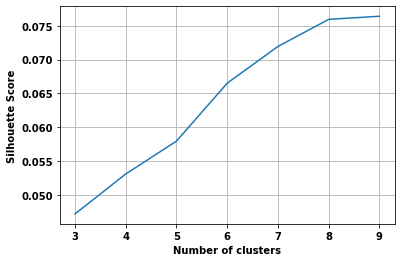

In [100]:
plt.plot(range(3,10), scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid('True')

7 Cluster seems to be optimal

In [101]:
# sorting the cluster centers for 5 clusters
sorted_vals = [km_5.cluster_centers_[i].argsort() for i in range(0,np.shape(km_5.cluster_centers_)[0])]

In [102]:
# get top 10 words from that cluster
words=set()
for i in range(len(km_5.cluster_centers_)):
    words = set(vocab[sorted_vals[i][-10:]])
    print(words)

{'cjsc', 'motivated', 'manager', 'qualified', 'candidate', 'specialist', 'looking', 'professional', 'experienced', 'work'}
{'activity', 'responsible', 'supervision', 'operation', 'development', 'product', 'incumbent', 'service', 'management', 'work'}
{'responsible', 'support', 'activity', 'program', 'development', 'incumbent', 'implementation', 'management', 'project', 'work'}
{'responsible', 'support', 'customer', 'sale', 'candidate', 'seeking', 'specialist', 'manager', 'service', 'work'}
{'design', 'developer', 'web', 'development', 'team', 'product', 'software', 'engineer', 'looking', 'senior'}


In [103]:
# sorting the cluster centers for 6 clusters
sorted_vals = [km_6.cluster_centers_[i].argsort() for i in range(0,np.shape(km_6.cluster_centers_)[0])]

In [104]:
# get top 10 words from that cluster
words=set()
for i in range(len(km_6.cluster_centers_)):
    words = set(vocab[sorted_vals[i][-10:]])
    print(words)

{'cjsc', 'motivated', 'manager', 'qualified', 'candidate', 'specialist', 'looking', 'professional', 'experienced', 'work'}
{'activity', 'responsible', 'supervision', 'operation', 'development', 'product', 'incumbent', 'service', 'management', 'work'}
{'responsible', 'support', 'activity', 'development', 'looking', 'implementation', 'manager', 'management', 'project', 'work'}
{'responsible', 'motivated', 'customer', 'sale', 'seeking', 'incumbent', 'product', 'looking', 'manager', 'service'}
{'design', 'developer', 'seeking', 'web', 'development', 'team', 'senior', 'software', 'looking', 'engineer'}
{'activity', 'support', 'seeking', 'development', 'office', 'specialist', 'program', 'manager', 'service', 'work'}


Above analysis shows that in cluster 6 the tokens get repeated and clusters are more similar to each other. That means **cluster 5** is optimal. 

### IT Job Classification

In [105]:
class_data = jobs[(jobs.title.isna() == False) & (jobs.jobrequirment.isna() == False) & (jobs.requiredqual.isna() == False) &
                 (jobs.jobdescription.isna() == False) & (jobs.aboutc.isna() == False) & (jobs.company.isna() == False)]

In [106]:
class_data.shape

(8993, 24)

In [107]:
class_data.isna().sum()

jobpost                0
date                   0
title                  0
company                0
announcementcode    8379
term                4359
eligibility         6619
audience            8648
startdate           3830
duration            2860
location               1
jobdescription         0
jobrequirment          0
requiredqual           0
salary              3549
applicationp           0
openingdate          125
deadline               4
notes               8036
aboutc                 0
attach              8528
year                   0
month                  0
it                     0
dtype: int64

In [108]:
#identify Y variable
class_data['it'] = class_data.it.apply(lambda x : 0 if (x is False) else 1)
y=class_data['it']

C:\Users\Yoga 500\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [109]:
y.value_counts()

0    6780
1    2213
Name: it, dtype: int64

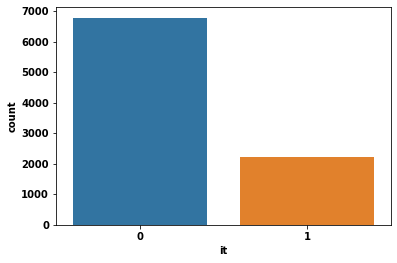

In [110]:
sns.countplot(y)

In [111]:
class_data = class_data['title'].str.cat(class_data['jobrequirment'], sep =" ").str.cat(class_data['requiredqual'], sep =" ").str.cat(
    class_data['jobdescription'], sep =" ").str.cat(class_data['aboutc'], sep =" ").str.cat(class_data['company'], sep =" ")
class_df = class_data

In [112]:
class_df.head()

2     Country Coordinator - Working with the Country...
22    Marketing Advisor - Lead the effort to identif...
56    Manufacturing Chief - To manage all manufactur...
64    Administrative Assistant/ Secretary - To welco...
67    Salesman / Trade agent - To distribute and dis...
Name: title, dtype: object

### Text pre-processing

In [113]:
class_df = class_df.apply(lambda x : clean_data(str(x)))
class_df.head()

2     country coordinator  working with the country ...
22    marketing advisor  lead the effort to identify...
56    manufacturing chief  to manage all manufacturi...
64    administrative assistant secretary  to welcome...
67    salesman  trade agent  to distribute and displ...
Name: title, dtype: object

In [114]:
#Lemmatization
class_df_1 = class_df.apply(lambda x : lemma(x))

In [115]:
class_df_1.head()

2     country coordinator working with the country d...
22    marketing advisor lead the effort to identify ...
56    manufacturing chief to manage all manufacturin...
64    administrative assistant secretary to welcome ...
67    salesman trade agent to distribute and display...
Name: title, dtype: object

In [116]:
#stop word removal
class_df_1 = class_df_1.apply(lambda x : ' '.join(x for x in x.split() if x not in stop))

In [117]:
class_df_1.head()

2     country coordinator working country director p...
22    marketing advisor lead effort identify target ...
56    manufacturing chief manage manufacturing funct...
64    administrative assistant secretary welcome vis...
67    salesman trade agent distribute display import...
Name: title, dtype: object

In [118]:
#Tokenization
tfidf_vect = TfidfVectorizer(ngram_range=(1,1), min_df = 0.05, max_df=0.95, stop_words='english')
x_tdm = tfidf_vect.fit_transform(class_df_1)
#print(x_tdm)

In [119]:
df_clust = pd.DataFrame(x_tdm.toarray(), columns=tfidf_vect.get_feature_names())

In [120]:
df_clust.head()

,ability,access,accordance,according,account,accountant,accounting,accuracy,accurate,achieve,...,window,word,work,working,world,write,writing,written,year,yerevan
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.000000,0.124273,0.0,0.0,0.0,0.063437,0.040290,0.000000
1,0.014898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.038868,0.031142,0.012675,0.000000,0.0,0.0,0.0,0.000000,0.043389,0.000000
2,0.032916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.000000,0.112018,0.000000,0.0,0.0,0.0,0.050313,0.031954,0.000000
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,...,0.000000,0.129004,0.000000,0.000000,0.0,0.0,0.0,0.094335,0.059912,0.122743
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32856,...,0.000000,0.000000,0.000000,0.177316,0.0,0.0,0.0,0.000000,0.229945,0.000000


## Building a Random Forest Model

#### Divide the data into train and test

In [121]:
df_clust.shape

(8993, 489)

In [122]:
from sklearn.model_selection import train_test_split

train_x, test_x,train_y, test_y = train_test_split(df_clust,y, test_size = 0.2, random_state = 5)
print(train_x.shape, test_x.shape)

(7194, 489) (1799, 489)


In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [314]:
param_grid = {'n_estimators':[120,130,150,160,180,200,300,400,500,600,700],
              'max_features':[9,10,13,15,17,19]}

grid_rf = GridSearchCV(estimator= RandomForestClassifier(),
                      param_grid=param_grid,
                      cv = 10,
                      n_jobs=-1)

grid_rf.fit(train_x,train_y)

GridSearchCV(cv=10, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rand

In [315]:
grid_rf.best_score_

0.9506517539792922

In [316]:
grid_rf.best_params_

{'max_features': 19, 'n_estimators': 180}

In [317]:
grid_rf.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=19,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [318]:
#Fit the model
rf_model = grid_rf.best_estimator_
rf_model.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=19,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=180,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Prdict the output for train and validation set

In [319]:
rf_train_predict = pd.DataFrame({'actual' : train_y,
                                 'predicted' : rf_model.predict(train_x)})
rf_train_predict.head()

,actual,predicted
18595,1,1
14290,1,1
12772,1,1
13946,0,0
9745,0,0


In [320]:
rf_test_predict = pd.DataFrame({'actual' : test_y,
                                 'predicted' : rf_model.predict(test_x)})
rf_test_predict.head()

,actual,predicted
8007,0,0
6159,0,0
9782,0,0
6132,0,0
6649,0,0


### Model Evaluation

In [321]:
#1. Check accuracy score on train and test

print('Accuracy Score for train dataset : ' , metrics.accuracy_score(rf_train_predict.actual, rf_train_predict.predicted))
print('Accuracy Score for test dataset : ' , metrics.accuracy_score(rf_test_predict.actual, rf_test_predict.predicted))

Accuracy Score for train dataset :  0.9998609952738393
Accuracy Score for test dataset :  0.9449694274596998


In [322]:
#2. Check roc_auc score on train and test

print('ROC-AUC Score for train dataset : ' , metrics.roc_auc_score(rf_train_predict.actual, rf_train_predict.predicted))
print('ROC-AUC Score for validation dataset : ' , metrics.roc_auc_score(rf_test_predict.actual, rf_test_predict.predicted))

ROC-AUC Score for train dataset :  0.9997209821428572
ROC-AUC Score for validation dataset :  0.9055173079508669


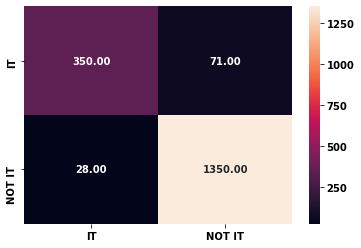

In [323]:
#3. Create confusion matrix
#for test

conn_cm_test = metrics.confusion_matrix(rf_test_predict.actual, rf_test_predict.predicted, [1,0])
sns.heatmap(conn_cm_test, fmt= '.2f', annot=True,  xticklabels=['IT', 'NOT IT'], yticklabels=['IT', 'NOT IT'])

In [324]:
#4. Create classification report
print(metrics.classification_report(rf_test_predict.actual, rf_test_predict.predicted))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1378
           1       0.93      0.83      0.88       421

    accuracy                           0.94      1799
   macro avg       0.94      0.91      0.92      1799
weighted avg       0.94      0.94      0.94      1799



In [325]:
indices = np.argsort(rf_model.feature_importances_)[::-1]
feature_rank = pd.DataFrame(columns = ['rank', 'feature', 'importance'])
for f in range(train_x.shape[1]):
    feature_rank.loc[f] = [f+1,
                          train_x.columns[indices[f]],
                          rf_model.feature_importances_[indices[f]]]
feature_rank.round(3)

,rank,feature,importance
0,1,developer,0.092
1,2,software,0.052
2,3,design,0.039
3,4,programming,0.026
4,5,sql,0.024
5,6,experience,0.022
6,7,code,0.021
7,8,web,0.021
8,9,javascript,0.020
9,10,development,0.019


In [326]:
feature_rank[:17]

,rank,feature,importance
0,1,developer,0.091986
1,2,software,0.052484
2,3,design,0.039021
3,4,programming,0.025965
4,5,sql,0.024310
5,6,experience,0.021616
6,7,code,0.020580
7,8,web,0.020533
8,9,javascript,0.020234
9,10,development,0.019417


Presence of keywords like software, developer, web, design, cs are the important feautures while clasifying any job as **IT or NON-IT**

### Similarity of Jobs

In [ ]:
###Using TF-IDF as cosine similarity

In [151]:
#from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def get_cosine_sim(doc): 
    vectors = [t for t in get_vectors(doc)]
    return cosine_similarity(vectors)
    
def get_vectors(doc):
    text = [t for t in doc]
    vectorizer = CountVectorizer(text)
    vectorizer.fit(text)
    return vectorizer.transform(text).toarray()

### Using word embeddings Doc2Vec

In [133]:
from gensim import utils
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec

In [295]:
jobpost_df_1.shape

(18892,)

In [138]:
#Pre-processed text of jobpost column
jobpost_df_1.head(10)

0    ameria investment consulting chief financial o...
1    international research exchanges board irex co...
2    caucasus environmental ngo network cenn countr...
3    manoff group bcc specialist manila philippines...
4    yerevan brandy software developer yerevan resp...
5    boutique appollo saleswoman yerevan work hours...
6    osi assistance foundation branch office chief ...
7    international research exchanges board irex pa...
8    yerevan brandy assistant managing director yer...
9    american embassy yerevan number program assist...
Name: jobpost, dtype: object

In [296]:
title_df_1.shape

(18892,)

In [175]:
#Pre-processed text of title column column
title_df_1.head()

0                        chief financial officer
1    community connection intern paid internship
2                            country coordinator
3                                 bcc specialist
4                             software developer
Name: title, dtype: object

#### 1. Create the tags with each post

In [294]:
df_sim = pd.concat([jobpost_df_1, title_df_1], axis = 1)
df_sim.loc[1810]

jobpost    kre consulting csql server programmer eligibil...
title                                 csql server programmer
Name: 1810, dtype: object

In [200]:
docs=[]
def fn_tag_doc(jobpost, title):
        docs.append(TaggedDocument(words = jobpost.split(), tags = [title]))     

df_sim.apply(lambda x : fn_tag_doc(x['jobpost'], x['title']), axis = 1)

0        None
1        None
2        None
3        None
4        None
5        None
6        None
7        None
8        None
9        None
10       None
11       None
12       None
13       None
14       None
15       None
16       None
17       None
18       None
19       None
20       None
21       None
22       None
23       None
24       None
25       None
26       None
27       None
28       None
29       None
         ... 
18971    None
18972    None
18973    None
18974    None
18975    None
18976    None
18977    None
18978    None
18979    None
18980    None
18981    None
18982    None
18983    None
18984    None
18985    None
18986    None
18987    None
18988    None
18989    None
18990    None
18991    None
18992    None
18993    None
18994    None
18995    None
18996    None
18997    None
18998    None
18999    None
19000    None
Length: 18892, dtype: object

In [312]:
docs[1]

TaggedDocument(words=['international', 'research', 'exchanges', 'board', 'irex', 'community', 'connections', 'intern', 'paid', 'internship', 'months', 'irex', 'main', 'office', 'yerevan', 'description', 'irex', 'currently', 'seeks', 'fill', 'paid', 'intern', 'community', 'connections', 'cc', 'program', 'based', 'yerevan', 'office', 'however', 'applicants', 'must', 'willing', 'travel', 'throughout', 'necessary', 'reports', 'directly', 'cc', 'program', 'manager', 'responsibilities', 'presenting', 'cc', 'program', 'interested', 'parties', 'assisting', 'planning', 'scheduling', 'programmatic', 'meetings', 'events', 'includes', 'coordinating', 'logistics', 'cc', 'staff', 'visitors', 'participants', 'assisting', 'program', 'staff', 'english', 'vice', 'versa', 'helping', 'create', 'maintain', 'update', 'cc', 'filing', 'system', 'databases', 'completing', 'general', 'administrative', 'tasks', 'cc', 'program', 'within', 'office', 'duties', 'assigned', 'needed', 'required', 'qualifications', 'de

#### 2. Build a Model to convert each document(jobpost) into vectors to be used to check similarity

In [202]:
model_sim = Doc2Vec(docs, dm=0, alpha = 0.025, min_alpha = 0.025, min_count = 0)  # use fixed learning rate

In [204]:
for epoch in range(10):
    model_sim.train(docs, total_examples= model_sim.corpus_count, epochs=model_sim.epochs)
    model_sim.alpha -= 0.002  # decrease the learning rate
    model_sim.min_alpha = model_sim.alpha  # fix the learning rate, no decay

#### 3.Check the similarity of a given job title and get top 10 jobposts similar to that job_title

In [313]:
model_sim.docvecs.most_similar(positive=[model_sim.infer_vector('chief financial officer'.split())],topn=10)

[('finance director', 0.5625116229057312),
 ('chief accountant', 0.5528969764709473),
 ('credit officer sevan branch', 0.5511462092399597),
 ('specialist reporting subdivision payment account', 0.5506600141525269),
 ('credit officer ararat', 0.5474196076393127),
 ('chief accountant armavir branch', 0.5470607280731201),
 ('microfinance officer', 0.5437276363372803),
 ('deputy chief accountant', 0.5420640110969543),
 ('credit officer sevan', 0.5419756174087524),
 ('chief engineer', 0.5417341589927673)]

Above shows **top 10 titles** which are similar to the title 'chief financial officer'.

In [307]:
#docs[0].tags

In [308]:
#tags_list=[]
#for i in range(0, df_sim.shape[0]):
#    c = str(docs[i].tags).replace('[', '')
#    c = c.replace(']', '')
#    c = c.replace("'", '')
#    tags_list.append(c)

In [309]:
#tags_list[0]

In [310]:
#sim_list = []
#for tag in tags_list:
    #print(model_sim.docvecs.similarity('bcc specialist', tag))
#    sim_list.append(model_sim.docvecs.similarity('software developer', tag))
    
#sim_list[0]

In [305]:
#sim_score_df = pd.concat([pd.Series(jobpost_df_1),pd.Series(tags_list), pd.Series(sim_list)], axis =1)
#sim_score_df.columns=['jobpost', 'title', 'similarity_score']
#sim_score_df
#sim_score_df.sort_values(by = 'similarity_score', ascending = False)